# Introduction

In this example, we calcuate $f_c(z)$ and compare against figure 22 in *arxiv*:1604.02457.  Therefore we will be studying dark matter decay into photons or electrons over a wide range of injection energy ($E_{inj}$) values.

In [1]:
%load_ext autoreload
import sys
sys.path.append("..")

#Current Working Directory
import os
cwd = os.getcwd()

from pathlib import Path

First we set our parameters to the ones used in 1604.02457.

In [2]:
%autoreload
import darkhistory.physics as phys
import numpy as np

phys.kB = 8.6173423e-5
phys.G = 6.6730e-8

kmperMpc = 3.08568025e19
amuperg = 6.0221415e23
eVperg = 5.60958921e32
nh0 = 0.022068*(1e2/kmperMpc)**2*amuperg*3/(8*np.pi*phys.G)

phys.omega_m       = 0.3175
phys.omega_rad     = 8e-5
phys.omega_lambda  = 0.6825
phys.omega_baryon  = 8*np.pi*phys.G/(3*phys.H0**2) * (nh0/amuperg)
phys.omega_DM      = phys.omega_m-phys.omega_baryon

phys.rho_DM=1274.4140

phys.nB = nh0
phys.rho_baryon = nh0*phys.mp

phys.YHe = .24

In [14]:
%autoreload

import matplotlib
matplotlib.rc_file('matplotlibrc')
import matplotlib.pyplot as plt

%matplotlib inline

matplotlib.rcParams['figure.figsize'] = [10,10]

from astropy.io import fits

import copy
import pickle

import darkhistory.utilities as utils
import darkhistory.spec.spectools as spectools
import darkhistory.spec.transferfunction as tf
import darkhistory.spec.transferfunclist as tflist
from darkhistory.spec.spectrum import Spectrum
from darkhistory.spec.spectra import Spectra
import darkhistory.history.tla as tla

from scipy.interpolate import interp1d
from scipy.interpolate import interp2d

from tqdm import tqdm_notebook as tqdm

from darkhistory.electrons.ics.ics_spectrum import ics_spec
from darkhistory.electrons.ics.ics_engloss_spectrum import engloss_spec
from darkhistory.electrons.ics.ics_cooling import get_ics_cooling_tf

from darkhistory.low_energy.lowE_deposition import compute_fs
import main

from tqdm import tqdm_notebook as tqdm

np.set_printoptions(threshold=np.nan)

Downloading ICS transfer functions.  If they haven't been made and pickled already, make them.

In [173]:
%autoreload
direc = cwd+'/../../tfs/ics/'
ics_file = Path(direc+'ics_thomson_ref_tf.p')

if ics_file.is_file():
    ics_thomson_ref_tf = pickle.load(open(direc+'ics_thomson_ref_tf.p', "rb"))
    ics_rel_ref_tf = pickle.load(open(direc+'ics_rel_ref_tf.p', "rb"))
    engloss_ref_tf = pickle.load(open(direc+'engloss_ref_tf.p', "rb"))
else:
    ics_thomson_ref_tf, ics_rel_ref_tf, engloss_ref_tf = main.load_ics_data()
    pickle.dump(ics_thomson_ref_tf, open(direc+'ics_thomson_ref_tf.p', "wb"))
    pickle.dump(ics_rel_ref_tf, open(direc+'ics_rel_ref_tf.p', "wb"))
    pickle.dump(engloss_ref_tf, open(direc+'engloss_ref_tf.p', "wb"))

# Specify Model

In [4]:
tau=.5e25

#Annihilation or decay?
inj_type = 'decay'

#Annihilate/Decay into
inj_particle = 'photon'

#Useful definitions
if inj_particle == 'electron':
    inj_str = 'elec'
    mass = phys.me
else:
    inj_str = 'phot'
    mass = 0

# Load IDL Files

Here we will download the data used in Fig. 22 of 1604.02457, dubbed the "IDL results" (since the code used to generate this data was written primarily in IDL).

### IDL parameters

Download the parameters used in the IDL files (file can be found at *erebus*@*lns.mit.edu:/zfs/gridgway/transferfuncs/ih_continuous_phot/tf_z_3.000E+03_nstep_6398_logE_1.021E+01_xe_0.000E+00.fits*)

In [5]:
# direc = cwd+'/../../ih_continuous_'+inj_str
user = '/Users/gregoryridgway'
direc = user+'/Dropbox (MIT)/Photon Deposition/idl_comparison/GR_Checks/ih_continuous_'

hdul = fits.open(direc+'elec/tf_z_3.000E+03_nstep_6398_logE_1.067E+01_xe_0.000E+00.fits')
direc = direc+inj_str
    
data = hdul[1].data

idl_photonspectrum = data.field('photonspectrum')[0]
idl_lowengphot = data.field('lowengphot')[0]
idl_lowengelec = data.field('lowengelec')[0]
idl_energy = data.field('energy')[0]
idl_eleceng = data.field('eleceng')[0]
idl_redshift = data.field('redshift')[0]
idl_cmblosstable = data.field('cmblosstable')[0]
idl_highengdep = data.field('highdeposited_grid')[0]

idl_bin_width = np.diff(np.log(spectools.get_bin_bound(data.field('energy')[0]))) * idl_energy
idl_elec_bin_width = np.diff(np.log(spectools.get_bin_bound(data.field('eleceng')[0]))) * idl_eleceng

xe_idl = data.field('hionfraction')[0]
xHe_idl = data.field('heionfraction')[0]

hdul.close()

xe_idl_func = interp1d(idl_redshift, xe_idl, bounds_error=False, fill_value=(xe_idl[-1], xe_idl[0]))
xHe_idl_func = interp1d(idl_redshift, xHe_idl, bounds_error=False, fill_value=(xHe_idl[-1], xHe_idl[0]))

The input energies used along the x-axis of Fig. 22 in 1604.02457

In [10]:
log10eng0 = 3.6989700794219966
log10eng = np.array([log10eng0 + 0.23252559*i for i in np.arange(40)])
log10eng[-1] = np.log10(idl_energy[-1])*.99

### IDL f(z)'s

Download the f(z)'s generated from IDL (can be found in `erebus:/zfs/gridgway/transferfuncs/ih_continuous_elec_v2/` for electrons and `erebus:/zfs/gridgway/transferfuncs/ih_continuous_phot/` for photons)

In [11]:
float_formatter = lambda x,n: ("{:."+str(n)+"E}").format(x,n)

rs_list = [3000*np.exp(-0.001*i) for i in np.arange(6398)]
f_idl_list = np.zeros((len(log10eng),5,6398))
for i, en in enumerate(log10eng[:-1]):
    hdul = fits.open(
        direc+'/calcfracs_tf_z_3.000E+03_nstep_6398_logE_'
        +float_formatter(np.log10(10**en+mass), 3)+'_xe_0.000E+00.fits'
    )

    data = hdul[1].data

    f_idl_low  = data.field('loweng_deposition_fractions')[0]
    f_idl_high = data.field('higheng_deposition_fractions')[0]
    idl_redshift     = data.field('redshift')[0]

#     f_idl_list[i,:] = f_idl_low + f_idl_high
    f_idl_list[i,:] = f_idl_low

    hdul.close()

### Contour Plots

To prove that we have actually downloaded the correct data, we reproduce the contour plots below.  The discrepancies between these contour plots and those in Fig. 22 come from interpolation errors in Fig. 22 that aren't in the below.

In [12]:
def get_fcontour(f_input, inj_type, inj_particle, channel):
    f_for_plot = f_input.copy()
    eng = 10**log10eng

    ind = {'H_ion' : 0, 'He_ion' : 1, 'exc' : 2, 'heat' : 3, 'cont' : 4}[channel]
    if ind < 2:
        label = {'H_ion' : 'H_{ion}', 'He_ion' : 'He_{ion}'}[channel]
    else:
        label = channel
    title = r'\bf{$f_{'+label+'}$}'
    
    ax = plt.gca()
    ax.set_xscale('log')
    ax.set_yscale('log')

    plt.axis([eng[0], 10**log10eng[-1], 5, 2e3])

    levels = np.array([1e-5, 1e-4, 1e-3, 5e-3, 1e-2, 5e-2, 1e-1, 3e-1, 1e0])
    if inj_type is 'decay':
        if channel is 'He_ion':
            if inj_particle is 'phot':
                levels = np.array([1e-7, 1e-6, 1e-5, 1e-4, 5e-4, 1e-3, 5e-3, 1e-2, 4e-2])
            else:
                levels = np.array([1e-6, 1e-5, 5e-5, 1e-4, 5e-4, 1e-3, 5e-3, 1e-2, 4e-2])
        elif channel is 'exc':
            if inj_particle is 'phot':
                levels = np.array([1e-5, 1e-4, 1e-3, 5e-3, 1e-2, 3e-2, 5e-2, 1e-1, 1e-0])
            else:
                levels = np.array([1e-4, 1e-3, 5e-3, 1e-2, 3e-2, 5e-2, 1e-1, 2e-1, 7e-1])
        elif (channel is 'heat') or (channel is 'cont'):
            if inj_particle is 'elec':
                levels = np.array([1e-5, 1e-4, 1e-3, 1e-2, 5e-2, 1e-1, 3e-1, 5e-1, 1, 2])
                
    f_for_plot[f_for_plot < levels[0]] = levels[0]*(1+.01)
    f_for_plot[f_for_plot > levels[-1]] = levels[-1]*(1-.01)
    
    levels2 = np.exp(np.linspace(np.log(levels[0]),np.log(levels[-1]),100))
    cs = ax.contourf(eng,idl_redshift,
                     np.transpose(f_for_plot[:,ind]), 
#                      locator=matplotlib.ticker.LogLocator(), 
                     norm=matplotlib.colors.LogNorm(),
                     levels=levels2,
                     cmap=matplotlib.cm.RdBu_r)
    ax.contour(eng,idl_redshift,
               np.transpose(f_for_plot[:,ind]),  
               levels=levels[1:-1],
               colors='k',
               alpha=.4
              )

    cbar = plt.colorbar(cs, ticks=levels)
    cbar.ax.set_xticklabels(str(levels))

    plt.title(title)
    plt.ylabel(r'Redshift ($1+z$)')
    plt.xlabel(r'Kinetic Energy [eV]')
    
#     plt.savefig(
#         cwd+'/../../../f'+inj_particle+'_'+inj_type+'_'+channel+'_contour.png'
#     )

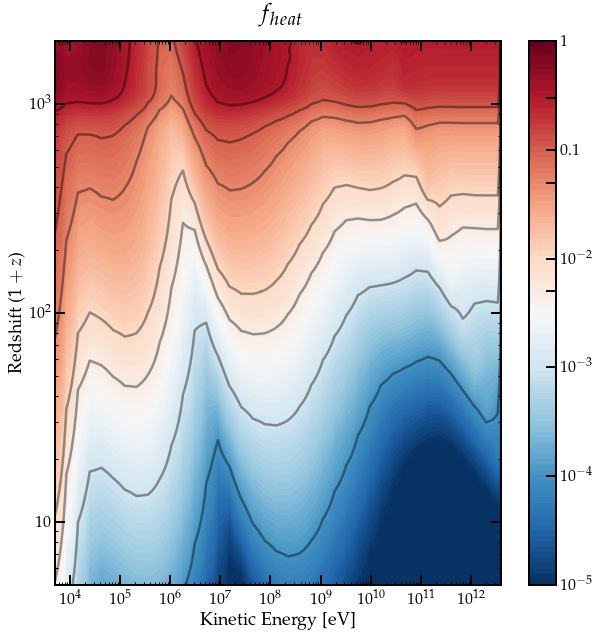

In [15]:
get_fcontour(f_idl_list,inj_type, inj_particle, 'heat')

# Compute DH f(z)'s

Now we reproduce the above f(z)'s.  We compute the energy deposition history for 40 different DM masses, i.e. 40 different columns of the above plot, each DM mass corresponding to an $E_{inj}$ stored in `log10eng`.

(Description of Tracy's injection of 2+epsilon particles method)

(rate functions in the form of $\frac{\rho (z)}{m_DM}$ for example)

In [36]:
if inj_type == 'decay':
    def struct_boost(rs):
        return 1
else:
    struct_data = np.loadtxt(open(cwd+"/../structure_formation_data/boost_Einasto_subs.txt", "rb"))
    log_struct_interp = interp1d(np.log(struct_data[:,0]), np.log(struct_data[:,1]))
    def struct_boost(rs):
        if rs<76:
            return np.exp(log_struct_interp(np.log(rs)))
        else:
            return 1

In [37]:
%autoreload

tau=3e27
sigmav=3e-27
def get_column(i, f_DH_list, inj_particle='electron', inj_type='decay', end_rs=4.995):
    """ Produce one column of the f differential plot
    """
    #injection energy, DM mass, center-of-mass energy
    Einj = 10**log10eng[i]
    mDM = 2*Einj + 2*mass
    Ecom=mDM
    
    def rate_func_N(rs):
        return phys.inj_rate(inj_type, rs, mDM=mDM, sigmav=sigmav, tau=tau)*struct_boost(rs)/Ecom
    def rate_func_eng(rs):
        return phys.inj_rate(inj_type, rs, mDM=mDM, sigmav=sigmav, tau=tau)*struct_boost(rs)
    
    if inj_type == 'swave':
        mDM = mDM/2
        Ecom = 2*mDM   
    
    if inj_particle == 'electron':
        Etmp = idl_eleceng[idl_eleceng < Einj][-1]
        elec_spec_init = spectools.rebin_N_arr(
            np.array([2*Einj/Etmp]),
            np.array([Etmp]),
            idl_eleceng
        )
        elec_spec_init.rs = 3000
        elec_spec_init.switch_spec_type()
        
        phot_spec_init = Spectrum(idl_energy,
                                 np.zeros_like(idl_energy),
                                 spec_type='N',
                                 rs=3000)
    else:
        Etmp = idl_energy[idl_energy < Einj][-1]
        phot_spec_init = spectools.rebin_N_arr(
            np.array([2*Einj/Etmp]),
            np.array([Etmp]),
            idl_energy
        )
        phot_spec_init.rs = 3000
        phot_spec_init.switch_spec_type()
        
        elec_spec_init = Spectrum(idl_eleceng,
                                 np.zeros_like(idl_eleceng),
                                 spec_type='N',
                                 rs=3000)

    f_DH_list[i] = main.evolve(
        in_spec_elec=elec_spec_init, in_spec_phot=phot_spec_init,
        rate_func_N=rate_func_N, rate_func_eng=rate_func_eng,
        DM_process=inj_type, mDM=mDM, sigmav=sigmav, lifetime=tau,
        start_rs = 3000, end_rs=end_rs,
        coarsen_factor=4, backreaction=False,
        struct_boost=struct_boost
    )

In [38]:
%autoreload
f_DH_data = [None for i in np.arange(40)]

for k in tqdm(np.arange(40)):
    get_column(k, f_DH_data, inj_particle=inj_particle, inj_type=inj_type, end_rs=4.995)
    
# f_DH_list = np.array([
#     f_DH[6] for f_DH in f_DH_data
# ])

# pickle.dump(f_DH_list, open(cwd+'/../../ih_continuous_'+inj_str+'/f_decay_'+inj_str+'.p', 'wb'))

KeyboardInterrupt: 

In [53]:
f_DH_data[0]['f']['low']['cont']/f_idl_list[0][4][::4]-1

/usr/local/Cellar/ipython/7.2.0/libexec/vendor/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


array([            nan,  3.15711922e-03, -1.58214039e-02,  2.18040316e-03,
       -1.75368326e-03, -3.03731815e-03, -3.56671786e-03, -3.76822976e-03,
       -4.06044404e-03, -4.25469750e-03, -4.42776306e-03, -4.62476065e-03,
       -4.83795836e-03, -4.98443028e-03, -5.20786365e-03, -4.99548019e-03,
       -1.24429945e-03, -6.56250002e-03, -9.21696342e-03, -1.27809404e-02,
       -1.49989850e-02, -1.53951261e-02, -1.53415872e-02, -1.67900963e-02,
       -1.50962616e-02, -1.47497552e-02, -1.46218721e-02, -1.44900169e-02,
       -1.43218086e-02, -1.41736444e-02, -1.39448791e-02, -1.37669461e-02,
       -1.36283623e-02, -1.34883119e-02, -1.29836672e-02, -1.75539657e-02,
       -2.12003863e-02, -2.22973948e-02, -2.20445276e-02, -2.14577788e-02,
       -2.09314142e-02, -2.06716291e-02, -2.02211215e-02, -1.98820811e-02,
       -1.95129339e-02, -1.92316691e-02, -1.88747445e-02, -1.86655910e-02,
       -1.83825678e-02, -1.81871576e-02, -1.80041428e-02, -2.00657923e-02,
       -2.40632380e-02, -

In [49]:
f_idl_list[0][0][::4]

array([0.00000000e+00, 1.57899177e-04, 2.07189416e-04, 2.11233796e-04,
       2.05174285e-04, 1.97646590e-04, 1.89915403e-04, 1.82693205e-04,
       1.75684893e-04, 1.69184070e-04, 1.62919614e-04, 1.57089189e-04,
       1.51495282e-04, 1.46272021e-04, 1.41280808e-04, 1.36604324e-04,
       1.32165854e-04, 1.28018916e-04, 1.24060873e-04, 1.20311040e-04,
       1.16810799e-04, 1.13462453e-04, 1.10365163e-04, 1.07365824e-04,
       1.04619499e-04, 1.01950698e-04, 9.95299965e-05, 9.71498640e-05,
       9.50128076e-05, 9.29059075e-05, 9.10089298e-05, 8.91482245e-05,
       8.74646876e-05, 8.58234236e-05, 8.43305919e-05, 8.28848601e-05,
       8.15636462e-05, 8.02899900e-05, 7.91207789e-05, 7.80011299e-05,
       7.69685951e-05, 7.59850742e-05, 7.50735480e-05, 7.42101133e-05,
       7.34061091e-05, 7.26494193e-05, 7.19409651e-05, 7.12799500e-05,
       7.06542617e-05, 7.00773038e-05, 6.95255632e-05, 6.90221872e-05,
       6.85358797e-05, 6.80970989e-05, 6.76690248e-05, 6.72868008e-05,
      

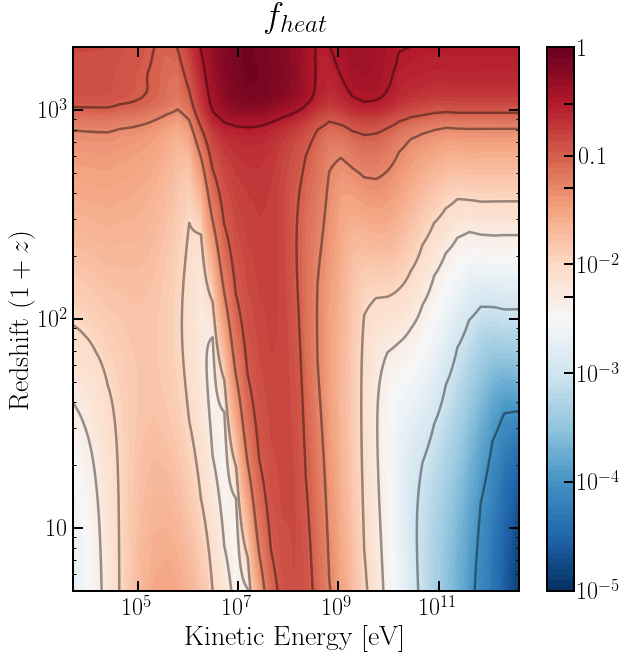

In [207]:
f_DH_tmp = np.swapaxes(f_DH_list[:,0],1,2)
get_fcontour(f_DH_tmp, inj_type, inj_particle, 'heat')

# Plot f contours

To see the level of discrepancy between the two data sets, is useful to plot the absolute residual difference between the two sets of f(z)'s.  We will find that we do better than 10% accuracy for essentially all of the data.

In [208]:
def get_fdiff(inj_type, inj_particle, channel):
    folder = inj_str+'_'+inj_type+'/'
    f_DH_tmp = f_DH_list[:,0]
    
    eng = 10**log10eng   

    rs_list = np.array([3000*np.exp(-0.001*i) for i in np.arange(6398)])

    ind = {'H_ion' : 0, 'He_ion' : 1, 'exc' : 2, 'heat' : 3, 'cont' : 4}[channel]
    if ind < 2:
        label = {'H_ion' : 'H_{ion}', 'He_ion' : 'He_{ion}'}[channel]
    else:
        label = channel
    title = r'\bf{$f_{'+label+'}$}'

    plt.figure()
    ax=plt.gca()
    ax.loglog()
    levels=[0,.01,.05,.1,.5]#,.2,.3,.4,.5,1]
    
    diffs = np.zeros_like(f_DH_tmp[:,:,ind])
    diffs = np.abs(
        f_DH_tmp[:,:,ind] - f_idl_list[:,ind]
    )/f_idl_list[:,ind]
    
    cs2 = ax.contourf(eng, rs_list, np.transpose(diffs), levels = levels,
                     cmap=matplotlib.cm.RdBu_r)
    cbar = plt.colorbar(cs2, ticks=levels)
    
    plt.title(title)
    plt.ylabel(r'Redshift ($1+z$)')
    plt.xlabel(r'Kinetic Energy [eV]')

#     plt.savefig(
#         cwd+'/../../'+folder+'f'+inj_particle+'_'+inj_type+'_'+channel+'_IDLdiffs.png'
#     )

/Users/gridgway/Desktop/DM/DarkHistory/examples/../../elec_decay/felec_decay_H_ion_IDLdiffs.png


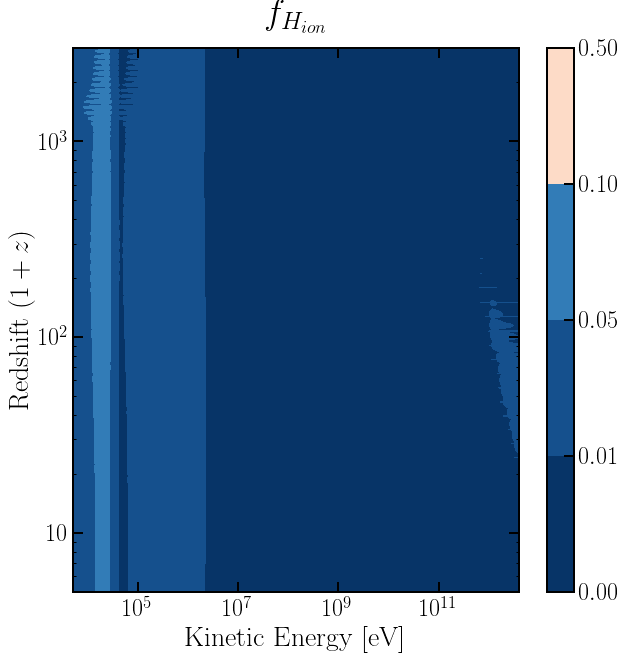

In [84]:
get_fdiff(inj_type, inj_str, 'H_ion')

Remember to:

    (1) Change back to DH parameters instead of IDL parameters (H0, etc.)
    (2) sum over partial bins (in the low energy electron methods)
    (3) off-by-one in the CMB subtraction

# SCRATCHWORK and NOTES

# Scratch

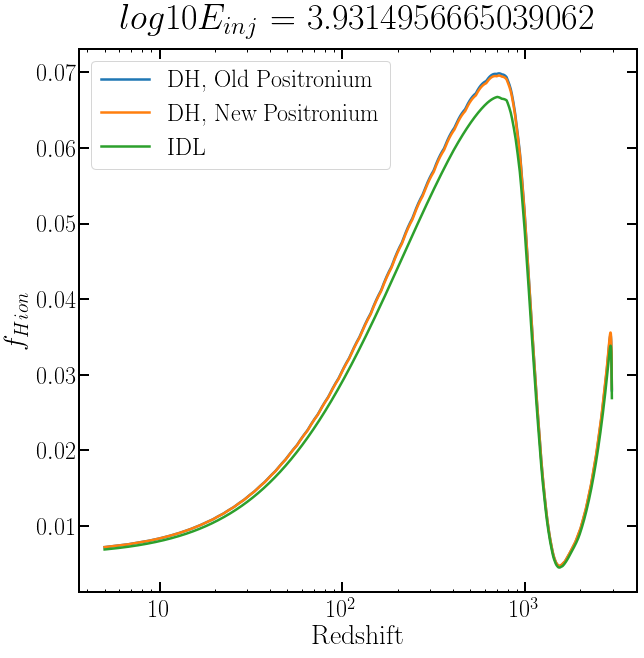

In [27]:
plt.figure()
ax = plt.gca()
ax.set_xscale('log')

Eind=1
ind=0

plt.title('$log10E_{inj}$ = '+str(log10eng[Eind]))
plt.plot(rs_list[10:-1], f_decay_elec[Eind,10:,ind], label='DH, Old Positronium')
plt.plot(rs_list[10:-1], data_elec[6][10:,ind], label='DH, New Positronium')
plt.plot(rs_list[10:-1], f_idl_list[Eind,ind,10:-1], label='IDL')

# plt.plot(rs_list[10:-1], (f_decay_elec[Eind,10:,ind]-f_idl_list[Eind,ind,10:-1])/f_idl_list[Eind,ind,10:-1], label='DH')

plt.ylabel(r'$f_{Hion}$')
plt.xlabel(r'Redshift')

plt.legend()

# plt.savefig('/home/gridgway/Desktop/fHion_discrepancy')

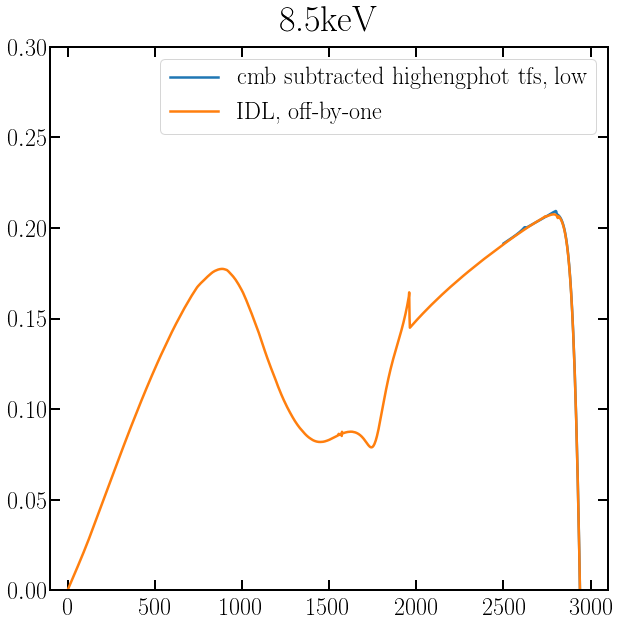

In [825]:
f_decay_phot0 = pickle.load(open("/home/gridgway/Dropbox (MIT)/Photon Deposition/f_decay_phot.p", "rb"))
rs_list = [3000*np.exp(-.001*i) for i in np.arange(6397)]

plt.figure()
ax=plt.gca()
# ax.loglog()
plt.axis([-100,3100,0,.3])
plt.title('8.5keV')


plt.plot(data_phot0[3].rs[:-1], data_phot0[6][0][:,4], label='cmb subtracted highengphot tfs, low')
# plt.plot(data_phot[3].rs[:-1], data_phot1[6][0][:,4], label='cmb subtracted lowengphot tfs, low')
# plt.plot(rs_list, f_decay_phot[1,:,4], label='cmb subtracted highengphot tfs')
# plt.plot(rs_list, f_decay_phot0[1,:,4], label='no cmb subtraction')
plt.plot(rs_list, f_idl_list[1,4,:-1], label='IDL, off-by-one')



# plt.plot(rs_list[10:], np.abs((f_idl_list[1,4,10:-1]-f_decay_phot[1,10:,4])/f_idl_list[1,4,10:-1]), label='IDL')
# plt.plot(rs_list[10:], np.abs((f_idl_list[1,4,10:-1]-f_decay_phot0[1,10:,4])/f_idl_list[1,4,10:-1]), label='IDL')

# plt.plot(data_phot[3].rs[:-1], data_phot[6][0][:,4]+data_phot[6][1][:,4], label='cmb subtracted highengphot tfs')

# plt.plot(idl_redshift[1:len(entries)+1], idl_flist[:,4], label='IDL, low')

# plt.plot(idl_redshift[:len(entries)], np.abs((idl_flist[:,4]-data_phot[6][0][:,4]-data_phot[6][1][:,4])/idl_flist[:,4]), label='IDL')

plt.legend()

# plt.savefig(
#     '/home/gridgway/Desktop/f_cont_offbyone_error.png'
# )

In [775]:
%autoreload
#fs from idl run
from darkhistory.low_energy.lowE_electrons import make_interpolator
from darkhistory.low_energy import lowE_deposition as lowE_dep
MEDEA_interp = make_interpolator()

E_tmp=10**log10eng[1]
entries=np.arange(4000)+1

idl_flist = [
    lowE_dep.compute_fs(
        MEDEA_interp,
        phot_spec=Spectrum(idl_energy, phot, rs=rs),
        elec_spec=Spectrum(idl_eleceng, elec*0, rs=rs),
        x = np.array([1-xe, 0, 0]),
        dt = .001/hub,
#         highengdep = highdep_interps.get_val(xe, rs)[indTmp],
        highengdep = highdeposited*np.array([1,1,1,0]),
        cmbloss = loss * hub/phys.hubble(rs*np.exp(.002)), #THIS factor of dt(z+2dz)/dt(z) compensates for IDL's off-by-one error
#         dE_dVdt_inj = phys.inj_rate('decay', rs, mDM=E_tmp, tau=tau)*2
        dE_dVdt_inj = 2*E_tmp*rate*phys.nB*rs**3
    )
    for xe, rs, phot, elec, loss, hub, rate, highdeposited in zip(data.field('hionfraction')[0][entries], 
                                   idl_redshift[entries],                            
                                   idl_lowengphot[entries],
                                   idl_lowengelec[entries],
                                   idl_cmblosstable[entries-1],
                                   data.field('hubblerate')[0][entries],
                                   data.field('annrate')[0][entries],
                                   np.transpose(idl_highengdep[:,entries]))]

idl_flist=np.array(idl_flist)

In [142]:
import multiprocessing  # the module we will be using for multiprocessing

def work(number):
    """
    Multiprocessing work
    
    Parameters
    ----------
    number : integer
        unit of work number
    """
    
    print("Unit of work number %d" % number)  # simply print the worker's number
    
def nonsense():
    print("There are %d CPUs on this machine" % multiprocessing.cpu_count())
    number_processes = 1
    pool = multiprocessing.Pool(number_processes)
    total_tasks = 4
    tasks = range(total_tasks)
    results = pool.map_async(get_column, tasks)
    print(results)
    pool.close()
    pool.join()

In [142]:
import multiprocessing  # the module we will be using for multiprocessing

def work(number):
    """
    Multiprocessing work
    
    Parameters
    ----------
    number : integer
        unit of work number
    """
    
    print("Unit of work number %d" % number)  # simply print the worker's number
    
def nonsense():
    print("There are %d CPUs on this machine" % multiprocessing.cpu_count())
    number_processes = 1
    pool = multiprocessing.Pool(number_processes)
    total_tasks = 4
    tasks = range(total_tasks)
    results = pool.map_async(get_column, tasks)
    print(results)
    pool.close()
    pool.join()

In [142]:
import multiprocessing  # the module we will be using for multiprocessing

def work(number):
    """
    Multiprocessing work
    
    Parameters
    ----------
    number : integer
        unit of work number
    """
    
    print("Unit of work number %d" % number)  # simply print the worker's number
    
def nonsense():
    print("There are %d CPUs on this machine" % multiprocessing.cpu_count())
    number_processes = 1
    pool = multiprocessing.Pool(number_processes)
    total_tasks = 4
    tasks = range(total_tasks)
    results = pool.map_async(get_column, tasks)
    print(results)
    pool.close()
    pool.join()

In [4]:
def get_fcontour(inj_type, inj_particle, channel):
    if inj_particle is 'elec':
        coarsen_factor = 16

        if inj_type is 'decay':
            f_for_plot = f_decay_elec.copy()
            folder='elec_decay/'

        elif inj_type is 'swave':
            f_for_plot = f_swave_elec.copy()
            folder='elec_swave/'
    else:
        coarsen_factor = 8

        if inj_type is 'decay':
            f_for_plot = f_decay_phot.copy()
            folder='phot_decay/'

        elif inj_type is 'swave':
            f_for_plot = f_swave_phot.copy()
            folder='phot_swave/'
    
    eng = 10**log10eng[:len(f_for_plot)]
    rs_list = [3000*np.exp(-0.001*coarsen_factor*(i)) for i in np.arange(6400/coarsen_factor)]

    if channel is 'H_ion':
        ind=0
        title = r'\bf{$f_{H ion}$}'
    elif channel is 'He_ion':
        ind=1
        title = r'\bf{$f_{He ion}$}'
    elif channel is 'exc':
        ind=2
        title = r'\bf{$f_{exc}$}'
    elif channel is 'heat':
        ind=3
        title = r'\bf{$f_{heat}$}'
    elif channel is 'cont':
        ind=4
        title = r'\bf{$f_{cont}$}'

    ax = plt.gca()
    ax.set_xscale('log')
    ax.set_yscale('log')

    plt.axis([eng[0], 10**log10eng[-1], 5, 2e3])

    levels = np.array([1e-5, 1e-4, 1e-3, 5e-3, 1e-2, 5e-2, 1e-1, 3e-1, 1e0])
    if inj_type is 'decay':
        if channel is 'He_ion':
            if inj_particle is 'phot':
                levels = np.array([1e-7, 1e-6, 1e-5, 1e-4, 5e-4, 1e-3, 5e-3, 1e-2, 4e-2])
            else:
                levels = np.array([1e-6, 1e-5, 5e-5, 1e-4, 5e-4, 1e-3, 5e-3, 1e-2, 4e-2])
        elif channel is 'exc':
            if inj_particle is 'phot':
                levels = np.array([1e-5, 1e-4, 1e-3, 5e-3, 1e-2, 3e-2, 5e-2, 1e-1, 1e-0])
            else:
                levels = np.array([1e-4, 1e-3, 5e-3, 1e-2, 3e-2, 5e-2, 1e-1, 2e-1, 7e-1])
        elif (channel is 'heat') or (channel is 'cont'):
            if inj_particle is 'elec':
                levels = np.array([1e-5, 1e-4, 1e-3, 1e-2, 5e-2, 1e-1, 3e-1, 5e-1, 1, 2])
    elif inj_type is 'swave':
        if channel is 'H_ion':
            if inj_particle is 'phot':
                levels = np.array([1e-3, 1e-2, 1e-1, 2e-1, 5e-1, 1, 5, 1e1, 5e1, 1e2])
        elif channel is 'He_ion':
            if inj_particle is 'phot':
                levels = np.array([5e-5, 1e-4, 1e-3, 5e-3, 1e-2, 5e-2, 1e-1, 5e-1, 2])
        elif channel is 'exc':
            if inj_particle is 'phot':
                levels = np.array([5e-3, 1e-2, 5e-2, 1e-1, 5e-1, 1, 5, 1e1, 1e2, 3e2])
        elif channel is 'heat':
            if inj_particle is 'phot':
                levels = np.array([1e-3, 1e-2, 2e-2, 5e-2, 1e-1, 2e-1, 5e-1, 1, 5, 1e1, 3e1])
        elif channel is 'cont':
            if inj_particle is 'phot':
                levels = np.array([1e-3, 1e-2, 2e-2, 5e-2, 1e-1, 5e-1, 1, 5, 1e1, 5e1, 1e2])

                
    f_for_plot[f_for_plot < levels[0]] = levels[0]*(1+.01)
    f_for_plot[f_for_plot > levels[-1]] = levels[-1]*(1-.01)
    
    levels2 = np.exp(np.linspace(np.log(levels[0]),np.log(levels[-1]),100))
    cs = ax.contourf(eng,rs_list,
                     np.transpose(f_for_plot[:,:,ind]), 
#                      locator=matplotlib.ticker.LogLocator(), 
                     norm=matplotlib.colors.LogNorm(),
                     levels=levels2,
                     cmap=matplotlib.cm.RdBu_r)
    ax.contour(eng,rs_list,
               np.transpose(f_for_plot[:,:,ind]),  
               levels=levels[1:-1],
               colors='k',
               alpha=.4
              )

    cbar = plt.colorbar(cs, ticks=levels)
    cbar.ax.set_xticklabels(str(levels))

    plt.title(title)
    plt.ylabel(r'Redshift ($1+z$)')
    plt.xlabel(r'Kinetic Energy [eV]')

#     direc = '/Users/GregoryRidgway/Desktop/Dark Matter/DH_Data/'
#     plt.savefig(
#         direc+'f'+inj_particle+'_'+inj_type+'_'+channel+'_contour.pdf'
#     )

### Structure Formation

In [ ]:
if inj_type == 'decay':
    def struct_boost(rs):
        return 1
else:
    struct_data = np.loadtxt(open(cwd+"/../structure_formation_data/boost_Einasto_subs.txt", "rb"))
    log_struct_interp = interp1d(np.log(struct_data[:,0]), np.log(struct_data[:,1]))
    def struct_boost(rs):
        if rs<76:
            return np.exp(log_struct_interp(np.log(rs)))
        else:
            return 1

# electon troubleshooting

In [157]:
Eind = 3
Elabel = float_formatter(np.log10(10**log10eng[Eind]+mass),3)

In [158]:
direc = cwd+'/../../ih_continuous_'+inj_str

hdul = fits.open(
    direc+'/IDL_runs/'
    +'tf_z_3.000E+03_nstep_6398_logE_'+Elabel+'_xe_0.000E+00.fits'
)
    
data = hdul[1].data

idl_photonspectrum = data.field('photonspectrum')[0]
idl_lowengphot = data.field('lowengphot')[0]
idl_lowengelec = data.field('lowengelec')[0]
idl_energy = data.field('energy')[0]
idl_eleceng = data.field('eleceng')[0]
idl_redshift = data.field('redshift')[0]
idl_cmblosstable = data.field('cmblosstable')[0]
idl_highengdep = data.field('highdeposited_grid')[0]

idl_bin_width = np.diff(np.log(spectools.get_bin_bound(data.field('energy')[0]))) * idl_energy
idl_elec_bin_width = np.diff(np.log(spectools.get_bin_bound(data.field('eleceng')[0]))) * idl_eleceng

xe_idl = data.field('hionfraction')[0]
xHe_idl = data.field('heionfraction')[0]

hdul.close()

xe_idl_func = interp1d(idl_redshift, xe_idl, bounds_error=False, fill_value=(xe_idl[-1], xe_idl[0]))
xHe_idl_func = interp1d(idl_redshift, xHe_idl, bounds_error=False, fill_value=(xHe_idl[-1], xHe_idl[0]))

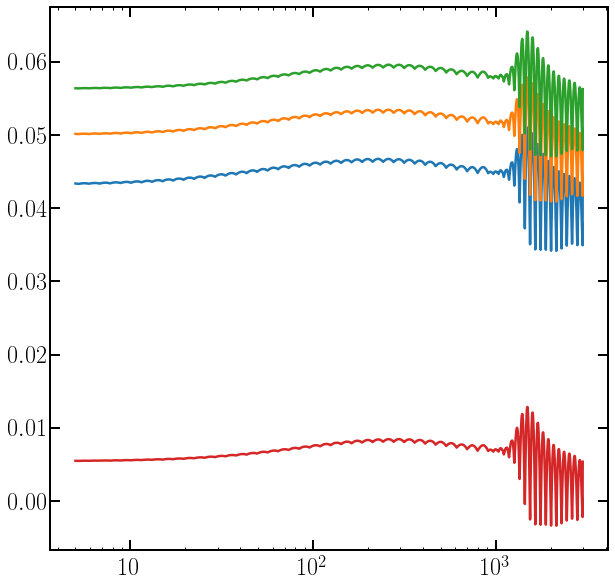

In [90]:
rs_list = np.array([3000*np.exp(-0.001*i) for i in np.arange(6398)])

tmp=3
ind=0
diffs = f_DH_list[:,0,:,ind]/f_idl_list[:,ind] - 1

plt.figure()
ax = plt.gca()
ax.set_xscale('log')
plt.plot(rs_list, diffs[tmp-2])
plt.plot(rs_list, diffs[tmp-1])
plt.plot(rs_list, diffs[tmp])
plt.plot(rs_list, diffs[tmp+1])

rs:  3.0E+03


/Users/gridgway/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide


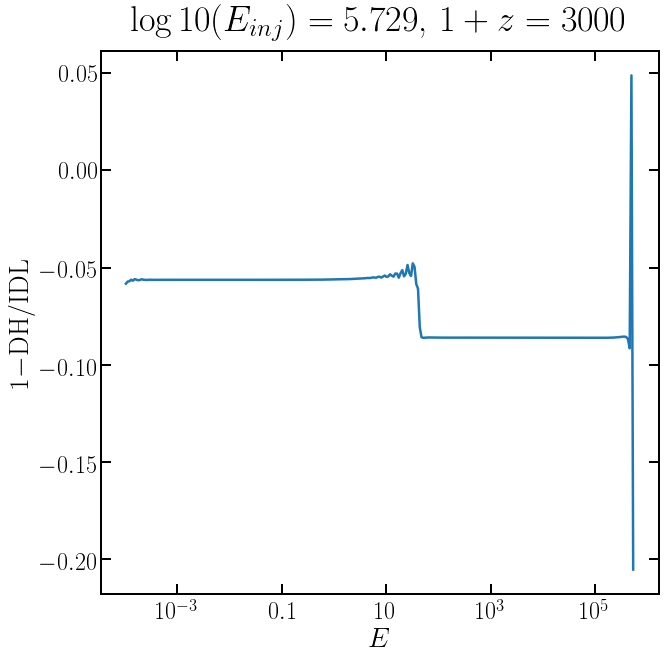

In [170]:
rsInd = 0
rsLabel = float_formatter(idl_redshift[rsInd], 1)
print("rs: ", rsLabel)

# EInd = len(photeng[photeng<Einj])
idl_spec = Spectrum(idl_energy,idl_photonspectrum[rsInd], spec_type='dNdE')
plt.figure()
ax = plt.gca()

# ax.loglog()
# ax.set_xlabel('$E$')
# ax.set_ylabel('$dN/dE$')
# plt.title('High Energy Photons, $1+z=$'+rsLabel[:1]+', $\log 10(E_{inj}) = '+Elabel[:5]+'$')
# plt.plot(photeng, idl_spec.N, label='IDL')
# plt.plot(photeng, f_DH_data[Eind][2]._grid_vals[rsInd], label='DH')
# plt.legend()

ax.set_xscale('log')
ax.set_xlabel('$E$')
ax.set_ylabel('$1-$DH/IDL')
plt.title('$\log 10(E_{inj}) = '+Elabel[:5]+'$, $1+z=3000$')
plt.plot(photeng, 1-f_DH_data[Eind][2]._grid_vals[rsInd]/idl_spec.N)

# plt.savefig(
#     cwd+'/../../../elec_dNdE_log10E_'+Elabel[:5]+'_rs3000.png'
# )
# plt.savefig(
#     cwd+'/../../../elec_dNdE_log10E_10.607_rs3000.png'
# )